# AT&T Spam Detector - BLOC 5
## PART 2 : Baseline Model
Developed by Myriam Goyet     
Contact : https://www.linkedin.com/in/myriamgoyet/

In [61]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, accuracy_score, precision_score, recall_score,confusion_matrix
from tensorflow.keras.optimizers import Adam

import os
import shutil
import joblib
import json

import matplotlib.pyplot as plt
import seaborn as sns


# 1. Load the dataset

In [40]:
df2 = pd.read_csv('AT&T_data_preprocessed.csv')
df2.head()

,target,messages,clean_data,clean_lemma
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don't think he goes to usf he lives arou...,nah think usf live


# 2. Preprocessing for baseline

In [41]:
# Replace missing values with an empty string and convert everything to strings
df2['clean_lemma'] = df2['clean_lemma'].fillna('').astype(str)

In [42]:
# Tokenize the cleaned messages using the Keras tokenizer to assign a value to each word, keeping only the 1,000 most common words.

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") # instanciate the tokenizer. all words not included in the 1,000 most common words will be considered out of vocab
tokenizer.fit_on_texts(df2["clean_lemma"])

df2.loc[:, "encoded"] = tokenizer.texts_to_sequences(df2["clean_lemma"])
df2

,target,messages,clean_data,clean_lemma,encoded
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,jurong point crazy available bugis n great wor...,"[1, 212, 411, 487, 846, 32, 52, 263, 847, 74, ..."
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni,"[10, 176, 1, 264, 2, 1]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[11, 335, 3, 698, 699, 39, 1, 978, 460, 1, 1, ..."
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun early hor u c,"[2, 114, 135, 1, 2, 76]"
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don't think he goes to usf he lives arou...,nah think usf live,"[660, 19, 603, 153]"
...,...,...,...,...,...
5164,1,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,2nd time try 2 contact u u win å750 pound priz...,"[272, 15, 48, 3, 93, 2, 2, 39, 1, 300, 72, 3, ..."
5165,0,Will Ì_ b going to esplanade fr home?,will ì b going to esplanade fr home,ì b esplanade fr home,"[37, 97, 1, 536, 23]"
5166,0,"Pity, * was in mood for that. So...any other s...",pity was in mood for that soany other suggestions,pity mood soany suggestion,"[1, 1, 1, 1]"
5167,0,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i'd...,guy bitching act like interested buy week free,"[110, 1, 1, 12, 1, 85, 40, 11]"


In [66]:
def save_tokenizer(tokenizer, save_dir, filename="tokenizer.json"):
    os.makedirs(save_dir, exist_ok=True)
    tokenizer_path = os.path.join(save_dir, filename)
    with open(tokenizer_path, "w") as f:
        f.write(tokenizer.to_json())
    print(f"✅ Tokenizer saved to: {tokenizer_path}")

In [67]:
save_tokenizer(tokenizer, "Models_trained", filename="tokenizer_baseline_model.json")

✅ Tokenizer saved to: Models_trained/tokenizer_baseline_model.json


In [43]:
# How are encoded messages lengths distributed?
sequence_lens = [len(seq) for seq in df2["encoded"]]
print("avg message len",np.mean(sequence_lens))
print("max message len",np.max(sequence_lens))

avg message len 7.823370090926678
max message len 74


In [44]:
# As all our sequences don't have the same number of values, we need to add zero padding at end of our sequences (padding="post") so they all have equal length.
max_len = np.max(sequence_lens)
messages_pad = tf.keras.preprocessing.sequence.pad_sequences(df2["encoded"], maxlen=max_len, padding='post')

In [45]:
# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Divide our dataset into Train and Validation sets. A sample of 70% will be saved for training set, and 30% for test sets.
xtrain, xval, ytrain, yval = train_test_split(messages_pad,df2["target"], stratify=df2["target"], test_size=0.3, random_state=seed)


In [46]:
# Form a tensor dataset by using a function call from_tensor_slices
# that converts tuples of arrays into tensor datasets
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

# Let's shuffle our tensor dataset and divide it to 64 batches and shuffle with seed for reproducibility.
# According to the size of our dataset and the memory of our GPU, 64 is a quite common batch size for a first test.
# Larger batch sizes can speed up the training process because they make better use of parallel processing capabilities of modern hardware. However, they might converge to a less optimal solution compared to smaller batch sizes.
# Smaller batch sizes can introduce more noise in the training process, which can sometimes help the model generalize better. However, too small batch sizes can make the training process unstable.
train_batch = train.shuffle(len(train), seed = seed).batch(64)
val_batch = val.shuffle(len(val), seed = seed).batch(64)

# 3. Building and training the model

In [47]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 accounts for the padding token 0
max_len = messages_pad.shape[1]  # messages length after padding
print("Vocab size : ",vocab_size)
print("max message len : ",max_len)

Vocab size :  8176
max message len :  74


In [48]:
# Architecture of the model. This is a simple sequential model.

model = tf.keras.Sequential([ # to create neural network models with layers stacked on top of each other
  tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=50, name="embedding"),  # Converts tokens into dense vectors of 50 dimensions
  tf.keras.layers.GlobalAveragePooling1D(),  # Averages the word embeddings across the sentence to reduce dimensions
  tf.keras.layers.Dense(16, activation='relu'),  # Hidden Dense layer with ReLU activation
  tf.keras.layers.Dense(1, activation="sigmoid")  # Output layer (Binary Classification)
])

optimizer = Adam(learning_rate=0.001)  # Default learning rate for the Adam optimizer
# with this optimizer, the learning rate will marginally adapt itself according to the value of the gradient.
# increasing when the gradient gets smaller to accelerate training
# decreasing when the gradient get bigger in order to prevent the training steps to go over a potential minimum.

# Binary Cross Entropy is a loss function ideal for binary classification problems
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    ]
)



In [49]:
# Let's start training our model :
# Setting 50 epochs
# Using validation_data to measure overfitting during training,
# the model will not train on this data but compute the performance metrics on it at the end of each epoch

start_time = time.time()

history = model.fit(
    train_batch,
    epochs=50,
    validation_data=val_batch
)

end_time = time.time()
training_time = end_time - start_time

print(f"⏱️ Training took {training_time:.2f} seconds ({training_time/60:.2f} minutes)")


Epoch 1/50


2025-07-08 16:26:18.668311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3618]
	 [[{{node Placeholder/_1}}]]
2025-07-08 16:26:18.668561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [3618]
	 [[{{node Placeholder/_1}}]]


57/57 [==============================] - 1s 5ms/step - loss: 0.5772 - accuracy: 0.8737 - val_loss: 0.4555 - val_accuracy: 0.8736
Epoch 2/50
18/57 [========>.....................] - ETA: 0s - loss: 0.4221 - accuracy: 0.8733

2025-07-08 16:26:19.215011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1551]
	 [[{{node Placeholder/_1}}]]
2025-07-08 16:26:19.215230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1551]
	 [[{{node Placeholder/_1}}]]


57/57 [==============================] - 0s 3ms/step - loss: 0.3795 - accuracy: 0.8737 - val_loss: 0.3446 - val_accuracy: 0.8736
Epoch 3/50
57/57 [==============================] - 0s 4ms/step - loss: 0.3329 - accuracy: 0.8737 - val_loss: 0.3257 - val_accuracy: 0.8736
Epoch 4/50
57/57 [==============================] - 0s 3ms/step - loss: 0.3095 - accuracy: 0.8737 - val_loss: 0.2990 - val_accuracy: 0.8736
Epoch 5/50
57/57 [==============================] - 0s 3ms/step - loss: 0.2723 - accuracy: 0.8734 - val_loss: 0.2543 - val_accuracy: 0.8743
Epoch 6/50
57/57 [==============================] - 0s 5ms/step - loss: 0.2197 - accuracy: 0.8958 - val_loss: 0.2038 - val_accuracy: 0.9117
Epoch 7/50
57/57 [==============================] - 0s 4ms/step - loss: 0.1736 - accuracy: 0.9334 - val_loss: 0.1686 - val_accuracy: 0.9381
Epoch 8/50
57/57 [==============================] - 0s 4ms/step - loss: 0.1425 - accuracy: 0.9544 - val_loss: 0.1451 - val_accuracy: 0.9478
Epoch 9/50
57/57 [=============

In [50]:
def save_model_to_dir(model, save_dir, filename="model.joblib"):
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, filename)
    if os.path.exists(model_path):
        os.remove(model_path)
    joblib.dump(model, model_path)
    print(f"✅ Model saved in : {model_path}")

In [51]:
save_model_to_dir(model=model, save_dir="Models_trained", filename="Baseline_model.joblib")

✅ Model saved in : Models_trained/Baseline_model.joblib


In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          408800    
                                                                 
 global_average_pooling1d_2   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 16)                816       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 409,633
Trainable params: 409,633
Non-trainable params: 0
_________________________________________________________________


# 4. Model evaluation

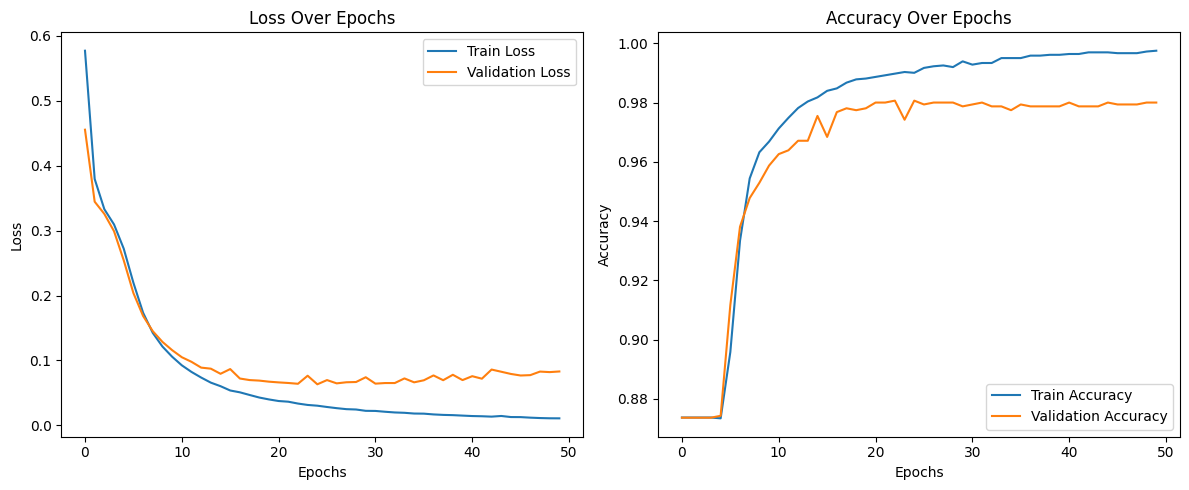

In [53]:
# Extract history
history_dict = history.history

# Create the plot
plt.figure(figsize=(12, 5))

# 📉 Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history_dict["loss"], label="Train Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# 📈 Plot Accuracy
plt.subplot(1, 2, 2)

# Handle accuracy key depending on the task
acc_key = "accuracy" if "accuracy" in history_dict else "binary_accuracy"
val_acc_key = "val_accuracy" if "val_accuracy" in history_dict else "val_binary_accuracy"

plt.plot(history_dict[acc_key], label="Train Accuracy")
plt.plot(history_dict[val_acc_key], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


Our model is learning fast but it starts to overfit around the 15th epoch.

In [62]:
# Function model evaluation for baseline model
   
def evaluate_model(model, xtrain, ytrain, xval, yval, model_name="baseline", output_dir="Evaluations"):    
    # Prediction
    y_pred_train = model.predict(xtrain)
    y_pred_train = np.where(y_pred_train < 0.5, 0, 1)
    y_pred_val = model.predict(xval)
    y_pred_val = np.where(y_pred_val < 0.5, 0, 1)

    # Classification report
    report_train = classification_report(ytrain, y_pred_train, output_dict=True)
    report_val = classification_report(yval, y_pred_val, output_dict=True)

    print("Classification_report - Training set")
    print(classification_report(ytrain, y_pred_train))

    print("Classification_report - Validation set")
    print(classification_report(yval, y_pred_val))

    # Heatmaps confusion matrix
    cm_train = confusion_matrix(ytrain, y_pred_train)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f"Confusion Matrix - Training ({model_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print()
    cm_val = confusion_matrix(yval, y_pred_val)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f"Confusion Matrix - Validation ({model_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Metrics summary
    summary_train = {
        "accuracy": accuracy_score(ytrain, y_pred_train),
        "precision": report_train["weighted avg"]["precision"],
        "recall": report_train["weighted avg"]["recall"],
        "f1-score": report_train["weighted avg"]["f1-score"]
    }

    summary_val = {
        "accuracy": accuracy_score(yval, y_pred_val),
        "precision": report_val["weighted avg"]["precision"],
        "recall": report_val["weighted avg"]["recall"],
        "f1-score": report_val["weighted avg"]["f1-score"]
    }

    # Create a folder if needed
    os.makedirs(output_dir, exist_ok=True)

    # Save metrics in a .json
    metrics = {
        "model_name": model_name,
        "train_metrics": report_train,
        "val_metrics": report_val,
        "train_summary": summary_train,
        "val_summary": summary_val
    }

    # Path
    json_path = os.path.join(output_dir, f"{model_name}_metrics.json")

    # Saving
    with open(json_path, "w") as f:
        json.dump(metrics, f, indent=4)

    print(f"✅ Metrics saved to {json_path}")

 51/114 [============>.................] - ETA: 0s

49/49 [==============================] - 0s 972us/step
Classification_report - Training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3161
           1       1.00      0.98      0.99       457

    accuracy                           1.00      3618
   macro avg       1.00      0.99      0.99      3618
weighted avg       1.00      1.00      1.00      3618

Classification_report - Validation set
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1355
           1       0.98      0.86      0.92       196

    accuracy                           0.98      1551
   macro avg       0.98      0.93      0.95      1551
weighted avg       0.98      0.98      0.98      1551



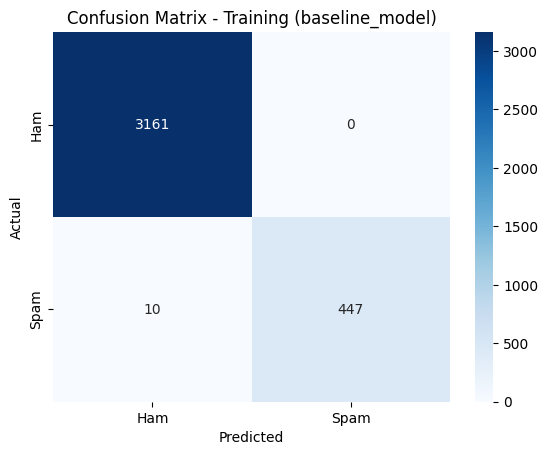

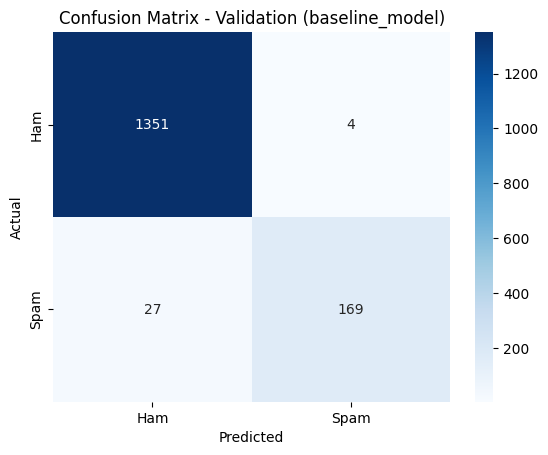

✅ Metrics saved to Evaluations/baseline_model_metrics.json


In [63]:
evaluate_model(model, xtrain, ytrain, xval, yval, model_name="baseline_model")


Indeed, if our scores are high on both the training and validation sets, our model is **slightly overfitting**, given that F1_train is 0.99 and F1_val is 0.92. Additionally, the recall for targeting spam is lower on the validation set (0.86 vs. 0.98 on the training set), meaning that the model is **less effective at identifying true positives (Spams)**.